In [80]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as D
import torch.optim as optim
from torch.utils.data import Dataset
from matplotlib import pyplot as plt
import numpy as np
import os, sys, psutil
from os.path import join, exists

In [81]:
latent_size = 1024 # latent space size
w = h = 256 # output of encoder size

class VAEModel(nn.Module):
    def __init__(self) -> None:
        super(VAEModel, self).__init__()
        self.activation = nn.LeakyReLU(0.05)
        self.encoder = nn.Sequential()
        for i in range(0, 6):
            self.encoder.append(nn.Sequential(
                nn.Conv2d(2**i, 2**(i+1), 4, 2, 1),
                self.activation,))

        self.decoder = nn.Sequential()
        for i in range(2, 7):
            self.decoder.append(nn.Sequential(
                nn.ConvTranspose2d(2**(8-i), 2**(7-i), 4, 2, 1),
                self.activation,))
        self.decoder.append(nn.Sequential(
            nn.ConvTranspose2d(2, 1, kernel_size = 4, stride = 2, padding=1),
            nn.Sigmoid()
            )
        )

        '''
        self.segmentation_decoder = nn.Sequential()
        for i in range(0, 7):
            self.segmentation_decoder.append(nn.Sequential(
                nn.ConvTranspose2d(2**(8-i), 2**(7-i), 4, 2, 1),
                self.activation,))
        self.segmentation_decoder.append(nn.Sequential(
            nn.ConvTranspose2d(2, 1, kernel_size = 4, stride = 2, padding=1),
            nn.Sigmoid()
            )
        )'''

        self.fc_mu = nn.Linear(1024, latent_size)
        self.fc_log_sigma = nn.Linear(1024, latent_size)
        self.latent_de = nn.Linear(1024, 1024)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.ConvTranspose2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
        
    
    def encode(self, x):
        h = self.encoder(x)
        h = h.view(-1, 1024)
        h = self.activation(h)
        mu = self.fc_mu(h)
        log_sigma = self.fc_log_sigma(h)
        return mu, log_sigma

    def decode(self, z):
        z = self.latent_de(z)
        z = self.activation(z)
        z = z.view(-1, 64, 4, 4)
        z = self.decoder(z)
        return z

    def reparameterize(self, mu, log_sigma):
        std = torch.exp(0.5*log_sigma)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def forward(self, x):
        x = x.view(-1, 1, w, h) # add channel dimension
        mu, log_sigma = self.encode(x) # log sigma is more stable (numerically)
        z = self.reparameterize(mu, log_sigma)
        x_hat = self.decode(z)
        return x_hat.view(-1, w, h), mu, log_sigma

In [82]:
model = VAEModel()

# Check model
A = torch.randn((10, 256, 256))
B, mu_B, log_sigma_B = model.forward(A)
B.shape, mu_B.shape, log_sigma_B.shape

(torch.Size([10, 256, 256]), torch.Size([10, 1024]), torch.Size([10, 1024]))

In [51]:
root_dir = '../' 
prep_data_dir = join(root_dir, 'augmenteddata')
class CT_Dataset(Dataset):
    def __init__(self, path, organ, mode):
        self.images = torch.load(
            join(path, organ + '_' + mode + '_image_slices.pt'))
        
        self.labels = torch.load(
            join(path, organ + '_' + mode + '_label_slices.pt'))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        return self.images[index], self.labels[index]

    def show_datapoint(self, index):
        image, label = self.__getitem__(index)
        fig, ax = plt.subplots(1, 2, figsize=(8,5))
        ax[0].imshow(image, interpolation='nearest')
        ax[1].imshow(label, interpolation='nearest')
        fig.canvas.draw()

training_set = CT_Dataset(prep_data_dir, 'lung', 'training')

In [52]:
def draw(x, x_hat):
    fig, axs = plt.subplots(1, 2, figsize=(8,5))
    img_0 = x[0].detach().numpy()
    img_1 = x_hat[0].detach().numpy()
    #img = img.reshape((-1, 28, 28)).transpose((1, 0, 2)).reshape(-1, 10*28)
    #img = img * 0.3081 + 0.1307
    axs[0].imshow(img_0, vmin=0, vmax=1, cmap='gray')
    axs[1].imshow(img_1, vmin=0, vmax=1, cmap='gray')
    fig.canvas.draw()

In [119]:
bce_loss = nn.BCELoss(reduction='mean')
def loss_fn(x, x_hat, mu, log_var): # input, reconstructed input
    x = x.reshape(x_hat.shape)
    BCE = bce_loss(x_hat, x)
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp()) # KL divergence
    KLD = KLD.mean() # average over batch
    loss = BCE + 1e-6*KLD # beta_norm*KLD # ELBO loss with beta_norm=0.1
    return loss

In [110]:
batch_size = 64

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")

In [55]:
def make_loaders(data):
    N = len(data)
    N_t = int(0.9*N)
    N_d = N - N_t
    train_data, dev_data = D.random_split(data, [N_t, N_d])
    train_loader = D.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    dev_loader = D.DataLoader(dev_data, batch_size=batch_size, shuffle=True)
    return train_loader, dev_loader

In [56]:
def train_epoch(model, optimizer, train_loader):
    model.train()
    losses = 0
    for data in train_loader:
        x = data[0].to(device)
        optimizer.zero_grad()
        x_hat, mu, log_var = model.forward(x)
        loss = loss_fn(x, x_hat, mu, log_var)
        loss.backward()
        optimizer.step()
        losses += loss.item()    
    return losses / len(train_loader)  # average loss

In [57]:
def evaluate(model, dev_loader):
    model.eval()
    losses = 0

    for data in dev_loader:
        x = data[0].to(device)
        x_hat, mu, log_var = model.forward(x)
        loss = loss_fn(x, x_hat, mu, log_var)
        losses += loss.item()

    return losses / len(dev_loader)

In [120]:
model = VAEModel()
lr = 3e-3
model = model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)
train_losses = []
dev_losses = []
lrs = []
train_loader, dev_loader = make_loaders(training_set)

In [121]:
from timeit import default_timer as timer
NUM_EPOCHS = 500

for epoch in range(1, NUM_EPOCHS+1):
    lrs.append(optimizer.param_groups[0]['lr'])
    start_time = timer()
    train_loss = train_epoch(model, optimizer, train_loader)
    train_losses.append(train_loss)
    end_time = timer()
    dev_loss = evaluate(model, dev_loader)
    dev_losses.append(dev_loss)
    scheduler.step()
    print((f"Epoch: {epoch}, Train loss: {train_loss:.4f}, Dev loss: {dev_loss:.4f}, "f"Epoch time = {(end_time - start_time):.3f}s"))

Epoch: 1, Train loss: 0.3705, Dev loss: 0.2856, Epoch time = 7.418s
Epoch: 2, Train loss: 0.2817, Dev loss: 0.2818, Epoch time = 7.153s
Epoch: 3, Train loss: 0.2792, Dev loss: 0.2800, Epoch time = 7.181s


tensor(0.0039) 0.27278006608997074


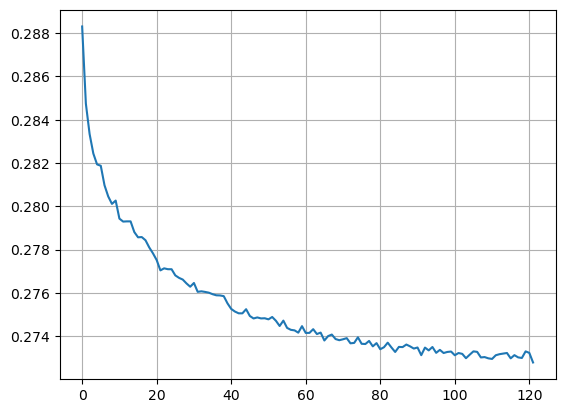

In [98]:
model_no = 49
torch.save(model, f'../saved_models/model_{model_no}')
torch.save(torch.Tensor(train_losses), f'../losses/train_losses_model_{model_no}')
torch.save(torch.Tensor(dev_losses), f'../losses/dev_losses_model_{model_no}')
dev_losses_2 = torch.load(f'../losses/dev_losses_model_{44}')
print(dev_losses_2[-1], dev_losses[-1])
#print(len(dev_losses_2), len(dev_losses))
#plt.plot((dev_losses_2))
plt.plot((dev_losses))
plt.grid()

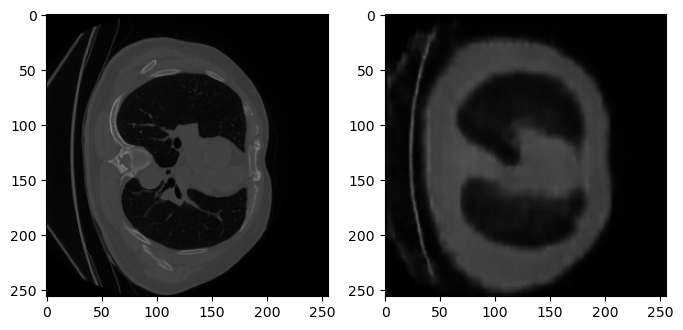

In [103]:
model.eval()
x_test = next(iter(dev_loader))[0][0].view(1, 256, 256).to(device)
#x_test = torch.zeros((1, 256, 256)).to(device)
x_hat_test = model.forward(x_test)[0]
draw(x_test.cpu(), x_hat_test.cpu())

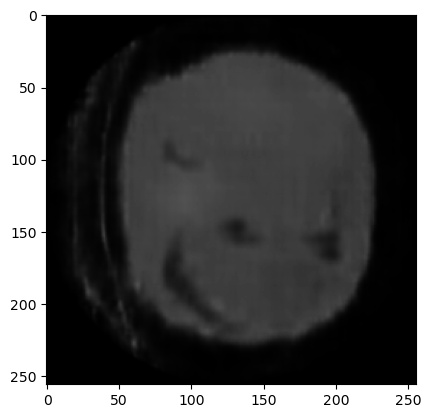

In [108]:
model.eval()
x_sampled = model.decode(torch.randn(1, latent_size).to(device)).view(1, 256, 256).cpu()
plt.imshow(x_sampled[0].detach().numpy(), vmin=0, vmax=1, cmap='gray')

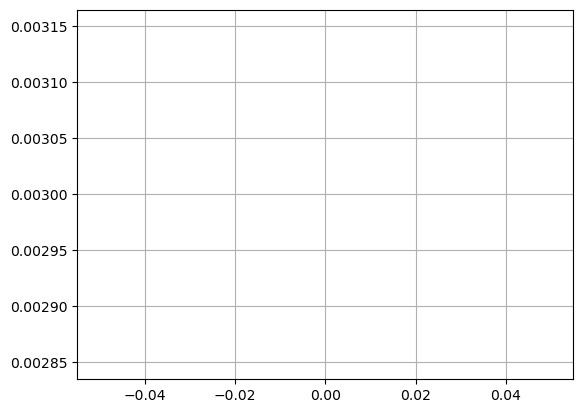

In [114]:
plt.plot(lrs)
plt.grid()